<a href="https://colab.research.google.com/github/egagli/amath563/blob/main/labs/3/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Pytorch Operators and Optimizers

## Assignment: Fashion MNIST Classification

In Lab3, we will use the Fashion MNIST dataset (see video recording for explanation of Fashion MNIST dataset). Similar to previous Lab2, you should design a fully-connected network as well as the pytorch based training/validation/testing process on the classification task. But differently, we will dive into the optimizers, operations or modules that we have learned in the lectures, and to see how they can benefit the capacity of your model.



1. Try different optimizers including RMSProp, Adam and SGD(You can find the corresponding functions in the torch.optim library). Log your training loss and test accuracy. Comparing these optimizers, how do they work? Which one is the best for this task and try to explain it.

2. Analyze the overfitting/underfitting situation of your model. Try to use regularization like L2/L1, Dropout layers, etc. to improve your performance. How does your regularization work? And how do you balance your regularization and the loss optimization?

3. Try different initialization ways like random normal, Xavier and He (Kaiming) etc. How can these initialization affect your training process and performance? 

4. Try normalization like batch normalization or layer normalization, whether these normalization methods can help your training or improve your performance?

5. To further improve the performance, you can also choose your own hyperparameters, including:
- Number of layers
- Number of neurons in each layer
- Learning rate
- Number of training epochs

For the comparing of different optimizers, regularization, initialization, normalization and hyper-parameters, you are recommended to form a table of the comparison results.  Report your loss as ”loss curve” and accuracy for different settings and draw conclusions. **You can split a small validation set from the training set to help you analyze the effectiveness of different modules better.**

For the convenient implementation of different optimizers, regularization, initialization and normalization, you can always check the tutorial of pytorch library (https://pytorch.org/tutorials/) for some useful funuctions and examples.

In [1]:
import torch
import torchvision
import tqdm
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt


train_batch_size =  50 # Define train batch size
test_batch_size  =  50 # Define test batch size (can be larger than train batch size)


# Use the following code to load and normalize the dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=train_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=test_batch_size, shuffle=True)

input_dim = 784

In [2]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 100)
    self.layer2 = nn.Linear(100, 100)
    self.layer3 = nn.Linear(100, 100)
    self.layer4 = nn.Linear(100, 10) 
  def forward(self, input):
    #How does your model process the input?
    x = F.relu(self.layer1(input))
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [3]:
# Define your optimizer
model = Network(input_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.8)
#torch.optim.Adam(model.parameters(),lr = 0.01, betas = (0.95, 0.998),eps = 1e-7)
#torch.optim.RMSprop()
loss_fn   = nn.CrossEntropyLoss() 

epochs = 10

loss_list     = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))


for epoch in tqdm.trange(epochs):
  for train_sample in train_loader:
    #Calculate training loss on model
    (imgs, labels) = train_sample
    flat = nn.Flatten(start_dim=1)
    imgs = flat(imgs)

    # Zero gradients
    optimizer.zero_grad()
    #Calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    loss_list[epoch] = loss.item()
    
    loss.backward()
    optimizer.step()

# Calculate accuracy on test set
  #for test_sample in test_loader:
  imgs_val, labels_val = next(iter(test_loader))
  imgs_val = flat(imgs_val)
  with torch.no_grad():
      y_pred = model(imgs_val)
      correct = (torch.argmax(y_pred, dim=1) == labels_val).type(torch.FloatTensor)
      accuracy_list[epoch] = correct.mean()

100%|██████████| 10/10 [01:46<00:00, 10.65s/it]


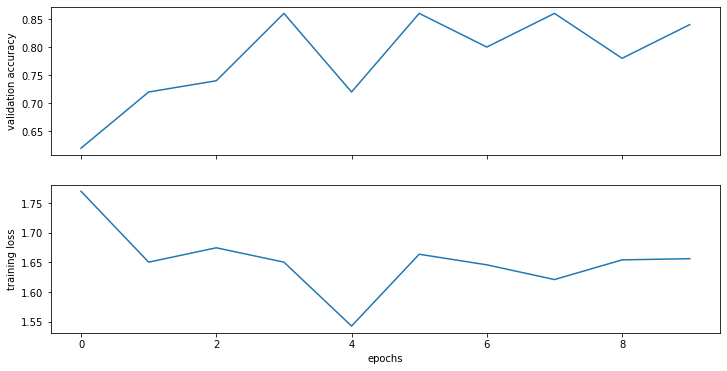

In [4]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("training loss")
ax2.set_xlabel("epochs");